In [1]:
import math
import os
from pathlib import Path
import sys
sys.path.insert(0, '..')
import pandas as pd
import matplotlib.pyplot as plt
import energy_flexibility_kpis.kpi.energy_flexibility.demand_profile_reshaping as demand_profile_reshaping
import energy_flexibility_kpis.kpi.energy_flexibility.demand_response_costs_or_savings as demand_response_costs_or_savings
import energy_flexibility_kpis.kpi.energy_flexibility.demand_response_emission_or_environmental_impact as demand_response_emission_or_environmental_impact
import energy_flexibility_kpis.kpi.energy_flexibility.demand_response_energy_efficiency as demand_response_energy_efficiency
import energy_flexibility_kpis.kpi.energy_flexibility.demand_response_profile_reshaping as demand_response_profile_reshaping
import energy_flexibility_kpis.kpi.energy_flexibility.energy_or_average_power_load_shedding as energy_or_average_power_load_shedding
import energy_flexibility_kpis.kpi.energy_flexibility.energy_storage_capability as energy_storage_capability
import energy_flexibility_kpis.kpi.energy_flexibility.grid_interaction as grid_interaction
import energy_flexibility_kpis.kpi.energy_flexibility.impact_on_ieq as impact_on_ieq
import energy_flexibility_kpis.kpi.energy_flexibility.load_shifting as load_shifting
import energy_flexibility_kpis.kpi.energy_flexibility.peak_power_or_energy_rebound as peak_power_or_energy_rebound
import energy_flexibility_kpis.kpi.energy_flexibility.peak_power_shedding as peak_power_shedding
import energy_flexibility_kpis.kpi.energy_flexibility.valley_filling as valley_filling
from energy_flexibility_kpis.utilities import FileHandler

# Package File Structure
---

In [2]:
!tree ../energy_flexibility_kpis -P '*.py' -I '__pycache__'

../energy_flexibility_kpis
├── __init__.py
├── base.py
├── enumerations.py
├── kpi
│   ├── __init__.py
│   ├── base.py
│   ├── energy_flexibility
│   │   ├── __init__.py
│   │   ├── demand_profile_reshaping.py
│   │   ├── demand_response_costs_or_savings.py
│   │   ├── demand_response_emission_or_environmental_impact.py
│   │   ├── demand_response_energy_efficiency.py
│   │   ├── demand_response_profile_reshaping.py
│   │   ├── energy_or_average_power_load_shedding.py
│   │   ├── energy_storage_capability.py
│   │   ├── grid_interaction.py
│   │   ├── impact_on_ieq.py
│   │   ├── load_shifting.py
│   │   ├── peak_power_or_energy_rebound.py
│   │   ├── peak_power_shedding.py
│   │   └── valley_filling.py
│   └── generic
│       ├── __init__.py
│       ├── building_energy_efficiency.py
│       ├── co2_emissions_or_environmental_impact.py
│       ├── cost_and_savings.py
│       └── grid_interaction.py
├── primitive_type.py
├── test
│   ├── __init__.py
│   └── test_kpi.py
├── unit.py
├── u

# How to get the info for a KPI
---

In [3]:
peak_power_shedding.PeakPowerReduction.info()

{'name': 'peak power reduction',
 'definition': 'Reduced power demand during peak hour due to flexible operation. The evaluation window should consider the peak hour after the fleible operation.',
 'unit': 'kW',
 'category': 'EF KPI: Peak Power Shedding',
 'relevance': 3,
 'stakeholders': ['distribution system operator',
  'transmisssion system operator'],
 'complexity': 1,
 'need_baseline': True,
 'temporal_evaluation_window': 'single event',
 'temporal_resolution': 'hourly',
 'spatial_resolution': 'unspecified',
 'doe_flexibility_category': ['load shedding'],
 'performance_aspect': ['power'],
 'calculation_arguments': [{'name': 'baseline electric power profile',
   'snake_case_name': 'baseline_electric_power_profile',
   'definition': 'A time series data points of electric power demand acquired in baseline operation scenario.',
   'primitive_type': {'name': 'power demand',
    'definition': 'An instantaneous power demand of a entity at a moment.',
    'unit': 'kW'},
   'value_type': 

# KPI Calculation Function Design Choices
---
1. All KPIs have a `calculate` function whose arguments refer to the variables listed in the [variables sheet](https://docs.google.com/spreadsheets/d/1tSN3PIu-lh9aSiU775-RULTRy2o2owIzV-iwymNXszo/edit#gid=118080661).
2. Every KPIs `calculate` function has positional arguments that must be provided and keyword arguments that are optional. The positional arguments will typically include power and energy profile e.g., `generic_electric_power_profile`, `flexible_electric_power_profile`, e.t.c. In some cases, `timestamps` variable is required e.g. in `energy_or_average_power_load_shedding.AnnualAverageDailyLoadVariation` where `timestamps` variable is needed to infer `hour-of-day` and `day-of-year` variables.
1. Every KPI's `calculate` function has `timestamps`, `evaluation_start_timestamp` and `evaluation_end_timestamp` as optional arguments so that the user can at any time supply the full power or energy profile and only need to control the `evaluation_start_timestamp` and `evaluation_end_timestamp` variables to consider specific time periods during calculation.
2. `timestamps` can be a datetime series of a timestep series i.e. integers.
3. KPIs that are defined for a building or DER cluster will take in a list of lists for some variables instead of taking in a single list of values
4. Writing all KPIs with the assumption that the input variables are in SI unit and values are reported as such eg. time in seconds, power in kW, energy in kWh.

# Dataset Configuration Template
---

In [4]:
FileHandler.read_yaml(filepath='../templates/dataset.yaml')

{'dataset': {'filepath': '/filepath/to/dataset',
  'resolution': {'temporal_resolution': 60,
   'spatial_resolution': {'single_resource': True}},
  'evaluation_period': {'start_timestamp': '2022-01-01 00:00:00',
   'end_timestamp': '2022-07-01 00:00:00'},
  'signal': {'variable_name': 'price',
   'high_threshold': None,
   'start_timestamp': None,
   'end_timestamp': None},
  'variable_name': {'building_id': {'name': 'building_id'},
   'availability': {'name': 'availability',
    'filepath': 'filepath/to/variable_name'},
   'timestamps': 'timestamps',
   'baseline_electric_power_profile': 'baseline_electric_power_profile',
   'baseline_electricity_consumption_profile': 'baseline_electricity_consumption_profile',
   'baseline_natural_gas_consumption_profile': 'baseline_natural_gas_consumption_profile',
   'flexible_electric_power_profile': 'flexible_electric_power_profile',
   'flexible_electricity_consumption_profile': 'flexible_electricity_consumption_profile',
   'flexible_natural_ga

# Importing a Dataset
---

In [5]:
# read test dataset
data_directory = Path('../data/test_dataset')
baseline_data = pd.read_csv(os.path.join(data_directory, 'baseline.csv'))
mpc_data = pd.read_csv(os.path.join(data_directory, 'mpc_results.csv'))
signal_data = pd.read_csv(os.path.join(data_directory, 'ToU.csv'))

print('Baseline:')
display(baseline_data.head(3))
display(baseline_data.describe(include='all'))

print('MPC (flexible):')
display(mpc_data.head(3))
display(mpc_data.describe(include='all'))

print('Signals:')
display(signal_data.head(3))
display(signal_data.describe(include='all'))

Baseline:


,Qh_hp,Qh_direct,Qh_other,I_solar,Ti,To,dt,Datetime,P_sig,Qh_hp_kWh,Energy_hp_kWh,Non-HVAC Power (W),Pre-event,Peak,Post-event
0,4187.394125,3.417003,566.443167,-0.031968,21.64400,2.618578,60.0,2021-12-17 00:00:00,7.0,0.069790,0.030926,81.704760,False,False,False
1,4274.190399,3.374273,565.407264,-0.027049,21.71392,2.627933,60.0,2021-12-17 00:01:00,7.0,0.071237,0.031567,81.483446,False,False,False
2,4327.706775,3.256316,563.102595,-0.026358,21.76967,2.611456,60.0,2021-12-17 00:02:00,7.0,0.072128,0.031963,81.457686,False,False,False


,Qh_hp,Qh_direct,Qh_other,I_solar,Ti,To,dt,Datetime,P_sig,Qh_hp_kWh,Energy_hp_kWh,Non-HVAC Power (W),Pre-event,Peak,Post-event
count,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.0,7200,7200.000000,7200.000000,7200.000000,7200.000000,7200,7200,7200
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7200,NaN,NaN,NaN,NaN,2,2,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-17 00:00:00,NaN,NaN,NaN,NaN,False,False,False
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,6300,6300,6300
mean,2549.045434,111.833323,998.582013,22.301885,22.006795,1.052031,60.0,NaN,7.625000,0.042484,0.018826,190.568583,NaN,NaN,NaN
std,2017.377974,132.771319,2932.083560,55.164745,0.354581,2.222733,0.0,NaN,1.653709,0.033623,0.014900,133.563404,NaN,NaN,NaN
min,64.867445,3.163889,6.116265,-0.038460,21.320835,-2.173728,60.0,NaN,7.000000,0.001081,0.000479,80.658477,NaN,NaN,NaN
25%,68.548241,3.431688,8.528444,-0.030933,21.706416,-0.535279,60.0,NaN,7.000000,0.001142,0.000506,82.337455,NaN,NaN,NaN
50%,4037.334454,123.158337,559.392989,-0.028055,21.994208,0.482192,60.0,NaN,7.000000,0.067289,0.029818,201.177613,NaN,NaN,NaN
75%,4423.142339,124.474212,565.220858,26.068965,22.269483,2.090403,60.0,NaN,7.000000,0.073719,0.032668,203.579599,NaN,NaN,NaN


MPC (flexible):


,Datetime,t_seconds,T_i,Qh_hp,T_o,T_set,T_comfort_u,T_comfort_l,I_sol,Q_in,P_sig,Cost,Qh_hp_kWh,Energy_hp_kWh,Non-HVAC Power (W),Pre-event,Peak,Post-event
0,2021-12-17 00:00:00,0.0,22.933165,-4.904006e-09,2.618578,22.222222,24.222222,21.722222,-0.031968,187.197800,7.0,-3.432804e-08,-8.173344e-14,-3.621898e-14,359.164843,False,False,False
1,2021-12-17 00:01:00,60.0,22.915338,3.539341e-06,2.627933,22.222222,24.222222,21.722222,-0.027049,187.473033,7.0,2.477539e-05,5.898902e-11,2.614012e-11,359.650083,False,False,False
2,2021-12-17 00:02:00,120.0,22.897539,3.588183e-06,2.611456,22.222222,24.222222,21.722222,-0.026358,187.415433,7.0,2.511728e-05,5.980306e-11,2.650085e-11,359.806033,False,False,False


,Datetime,t_seconds,T_i,Qh_hp,T_o,T_set,T_comfort_u,T_comfort_l,I_sol,Q_in,P_sig,Cost,Qh_hp_kWh,Energy_hp_kWh,Non-HVAC Power (W),Pre-event,Peak,Post-event
count,7200,7200.000000,7200.000000,7.200000e+03,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7.200000e+03,7.200000e+03,7.200000e+03,7200.000000,7200,7200,7200
unique,7200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2
top,2021-12-17 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6300,6300,6300
mean,NaN,215970.000000,20.115428,1.903073e+03,1.052031,20.333333,22.333333,19.833333,22.301885,134.412867,7.625000,2.109707e+04,3.171789e-02,1.405532e-02,307.450043,NaN,NaN,NaN
std,NaN,124716.318098,3.597299,1.354544e+03,2.222733,3.778040,3.778040,3.778040,55.164745,58.644755,1.653709,4.282612e+04,2.257574e-02,1.000411e-02,58.774478,NaN,NaN,NaN
min,NaN,0.000000,11.853540,-4.904006e-09,-2.173728,12.777778,14.777778,12.277778,-0.038460,64.264500,7.000000,-3.432804e-08,-8.173344e-14,-3.621898e-14,233.322243,NaN,NaN,NaN
25%,NaN,107985.000000,21.392214,1.051785e+03,-0.535279,22.222222,24.222222,21.722222,-0.030933,66.468825,7.000000,9.812336e+03,1.752975e-02,7.768055e-03,239.691970,NaN,NaN,NaN
50%,NaN,215970.000000,21.499394,2.136791e+03,0.482192,22.222222,24.222222,21.722222,-0.028055,185.671383,7.000000,1.568293e+04,3.561319e-02,1.578146e-02,357.092468,NaN,NaN,NaN
75%,NaN,323955.000000,21.519858,2.491878e+03,2.090403,22.222222,24.222222,21.722222,26.068965,187.551017,7.000000,1.773057e+04,4.153131e-02,1.840399e-02,360.512897,NaN,NaN,NaN


Signals:


,Datetime,ToU,Post-event,Pre-event,Peak
0,2021-12-17 00:00:00,7,False,False,False
1,2021-12-17 00:01:00,7,False,False,False
2,2021-12-17 00:02:00,7,False,False,False


,Datetime,ToU,Post-event,Pre-event,Peak
count,7200,7200.000000,7200,7200,7200
unique,7200,NaN,2,2,2
top,2021-12-17 00:00:00,NaN,False,False,False
freq,1,NaN,6300,6300,6300
mean,NaN,7.625000,NaN,NaN,NaN
std,NaN,1.653709,NaN,NaN,NaN
min,NaN,7.000000,NaN,NaN,NaN
25%,NaN,7.000000,NaN,NaN,NaN
50%,NaN,7.000000,NaN,NaN,NaN
75%,NaN,7.000000,NaN,NaN,NaN


# Map Dataset to EFOnt Variables
---

In [6]:
# map variables
data = pd.DataFrame({
    'timestamp': pd.to_datetime(mpc_data['Datetime']),
    'baseline_electric_power_profile': baseline_data['Qh_hp'],
    'flexible_electric_power_profile': mpc_data['Qh_hp'],
    'baseline_electricity_consumption_profile': baseline_data['Qh_hp_kWh'],
    'flexible_electricity_consumption_profile': mpc_data['Qh_hp_kWh'],
    'signal': signal_data['Peak']
})

# label peak events
data['event_reference'] = data.groupby((data['signal'] != data['signal'].shift(1)).cumsum()).ngroup()
events = data[data['signal']==True]['event_reference'].unique()
evaluation_timestamps = [(
    data[data['event_reference']==e]['timestamp'].min(),
    data[data['event_reference']==e]['timestamp'].max(),
) for e in events]

# set availability variable
data['availability'] = 0
data.loc[data['signal']==True, 'availability'] = 1

# Single Building/Resource KPIs
---

In [7]:
values_list = []

for s, e in evaluation_timestamps:
    values = []
    
    # Peak power shedding
    values.append((
        peak_power_shedding.PeakPowerReduction.NAME, 
        peak_power_shedding.PeakPowerReduction.calculate(
            data.baseline_electric_power_profile.tolist(),
            data.flexible_electric_power_profile.tolist(),
            timestamps=data.timestamp.tolist(),
            evaluation_start_timestamp=s,
            evaluation_end_timestamp=e,
    )))

    values.append((
        peak_power_shedding.HourlyRelativePowerDemandReduction.NAME,
        peak_power_shedding.HourlyRelativePowerDemandReduction.calculate(
            data.baseline_electric_power_profile.tolist(),
            data.flexible_electric_power_profile.tolist(),
            timestamps=data.timestamp.tolist(),
            evaluation_start_timestamp=s,
            evaluation_end_timestamp=e,
    )))

    values.append((
        peak_power_shedding.RelativePeakPowerDemandReduction.NAME,
        peak_power_shedding.RelativePeakPowerDemandReduction.calculate(
            data.baseline_electric_power_profile.tolist(),
            data.flexible_electric_power_profile.tolist(),
            timestamps=data.timestamp.tolist(),
            evaluation_start_timestamp=s,
            evaluation_end_timestamp=e,
    )))

    # Energy or average power load shedding
    values.append((
        energy_or_average_power_load_shedding.EnergyDeviationForPeakShaving.NAME,
        energy_or_average_power_load_shedding.EnergyDeviationForPeakShaving.calculate(
            data.baseline_electric_power_profile.tolist(),
            data.flexible_electric_power_profile.tolist(),
            timestamps=data.timestamp.tolist(),
            evaluation_start_timestamp=s,
            evaluation_end_timestamp=e,
    )))

    values.append((
        energy_or_average_power_load_shedding.AverageLoadReduction.NAME,
        energy_or_average_power_load_shedding.AverageLoadReduction.calculate(
            data.baseline_electric_power_profile.tolist(),
            data.flexible_electric_power_profile.tolist(),
            s,
            e,
            timestamps=data.timestamp.tolist(),
            evaluation_start_timestamp=s,
            evaluation_end_timestamp=e,
    )))

    values.append((
        energy_or_average_power_load_shedding.BuildingEnergyFlexibilityIndex.NAME,
        energy_or_average_power_load_shedding.BuildingEnergyFlexibilityIndex.calculate(
            data.baseline_electric_power_profile.tolist(),
            data.flexible_electric_power_profile.tolist(),
            timestamps=data.timestamp.tolist(),
            evaluation_start_timestamp=s,
            evaluation_end_timestamp=e,
    )))

    values.append((
        energy_or_average_power_load_shedding.DimensionlessPeakShaving.NAME,
        energy_or_average_power_load_shedding.DimensionlessPeakShaving.calculate(
            data.baseline_electric_power_profile.tolist(),
            data.flexible_electric_power_profile.tolist(),
            timestamps=data.timestamp.tolist(),
            evaluation_start_timestamp=s,
            evaluation_end_timestamp=e,
    )))

    values.append((
        energy_or_average_power_load_shedding.LoadFactor.NAME,
        energy_or_average_power_load_shedding.LoadFactor.calculate(
            data.flexible_electric_power_profile.tolist(),
            timestamps=data.timestamp.tolist(),
            evaluation_start_timestamp=s,
            evaluation_end_timestamp=e,
    )))

    values.append((
        energy_or_average_power_load_shedding.AnnualAverageDailyLoadVariation.NAME,
        energy_or_average_power_load_shedding.AnnualAverageDailyLoadVariation.calculate(
            generic_electric_power_profile=data.flexible_electric_power_profile.tolist(),
            timestamps=data.timestamp.tolist(),
    )))

    values_list.append(values)

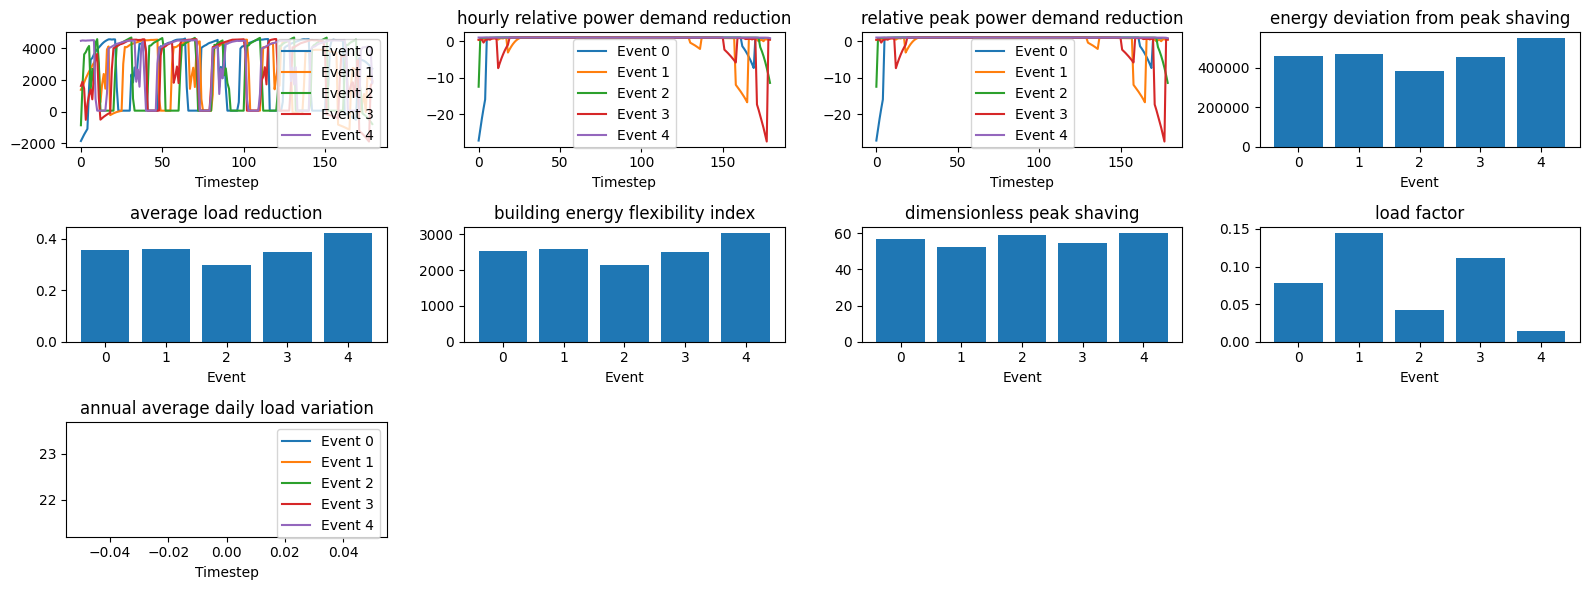

In [8]:
# plot results
kpis = [v[0] for v in values_list[0]]
column_count_limit = 4
row_count = math.ceil(len(kpis)/column_count_limit)
column_count = min(column_count_limit, len(kpis))
fig, _ = plt.subplots(row_count, column_count, figsize=(4*column_count, 2*row_count))

for ax in fig.axes[len(kpis):]:
    fig.delaxes(ax)

for i, (ax, kpi) in enumerate(zip(fig.axes, kpis)):
    values = [v[i][1] for v in values_list]

    if isinstance(values[0], float):
        x = list(range(len(evaluation_timestamps)))
        ax.bar(x, values)
        ax.set_xlabel('Event')
        
    else:
        for j, v in enumerate(values):
            ax.plot(v, label=f'Event {j}')
        
        ax.set_xlabel('Timestep')
        ax.legend()

    ax.set_title(kpi)

plt.tight_layout()
plt.show()

# Building/Resource Cluster KPIs

In [9]:
value = energy_or_average_power_load_shedding.PriceResponsiveness.calculate(
    [
        data.baseline_electric_power_profile.tolist(), 
        data.baseline_electric_power_profile.tolist()
    ],
    [
        data.flexible_electric_power_profile.tolist(), 
        data.flexible_electric_power_profile.tolist()
    ],
    timestamps=data.timestamp.tolist(),
    evaluation_start_timestamp=s,
    evaluation_end_timestamp=e,
)

value = peak_power_shedding.PowerPaybackRatio.calculate(
    [
        data.availability.tolist(),
        data.availability.tolist(),
    ],
    [
        data.baseline_electric_power_profile.tolist(), 
        data.baseline_electric_power_profile.tolist()
    ],
    [
        data.flexible_electric_power_profile.tolist(), 
        data.flexible_electric_power_profile.tolist()
    ],
    timestamps=data.timestamp.tolist(),
    evaluation_start_timestamp=s,
    evaluation_end_timestamp=e,
)

../energy_flexibility_kpis/kpi/energy_flexibility/energy_or_average_power_load_shedding.py:375: RuntimeWarning: divide by zero encountered in double_scalars
  value = numerator/denominator


# Open Questions
---
1. How do we standardize datasets in preparation for use in the package?
1. We can infer KPIs that are for clusters using the `KPI.SPATIAL_RESOLUTION`. How can we distinguish between datasets that are for a single building, cluster of buildings, cluster of DERs. This is most important in the Dash app since people using 
2. Can the evaluation period be synonymous with the grid signal period?